In [1]:
from random import shuffle
import os
import glob
import scipy
from scipy import ndimage
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_util import *

from keras.utils import to_categorical

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Read dataset from .hdf5

In [2]:
shuffle_data = True

height = 122
width = 122

target_label = {"0": "UNK", "1": "5c", "2": "10c", "3": "25c", "4": "$1", "5": "$2"}
label_target = reverse_dict(target_label)

In [3]:
outfile_path = "train_cropped_coin_" + str(height) + "_" + str(width) + ".hdf5"

In [4]:
train_set_x, train_set_y, _, _, _, _, classes = load_all_data(outfile_path)

In [5]:
outfile_path = "dev_cropped_coin_" + str(height) + "_" + str(width) + ".hdf5"

In [6]:
_, _, dev_set_x, dev_set_y, _, _, classes = load_all_data(outfile_path)

In [7]:
outfile_path = "test_cropped_coin_" + str(height) + "_" + str(width) + ".hdf5"

In [8]:
_, _, _, _, test_set_x, test_set_y, classes = load_all_data(outfile_path)

In [9]:
print("X_train shape: " + str(train_set_x.shape))
print("Y_train shape: " + str(train_set_y.shape))
print("X_dev shape: " + str(dev_set_x.shape))
print("Y_dev shape: " + str(dev_set_y.shape))
print("X_test shape: " + str(test_set_x.shape))
print("Y_test shape: " + str(test_set_y.shape))

print("Classes are: " + str(classes))

X_train shape: (768, 122, 122, 3)
Y_train shape: (768, 1)
X_dev shape: (192, 122, 122, 3)
Y_dev shape: (192, 1)
X_test shape: (192, 122, 122, 3)
Y_test shape: (192, 1)
Classes are: ['UNK' '5c' '10c' '25c' '$1' '$2']


#### Sanity check and visualize a few random chosen images

In [ ]:
for i in range(5):
    index = np.random.randint(len(train_set_y_orig))
    #print(target_label[str(train_set_y_orig[index][0])])
    plt.figure(i, figsize=(5, 5))
    plt.title(target_label[str(train_set_y_orig[index][0])])
    plt.imshow(train_set_x_orig[index])

Reshape/Flatten X such that it can be fed into a feedforward net

In [ ]:
train_set_x = train_set_x.reshape((-1, 122*122*3))
dev_set_x = dev_set_x.reshape((-1, 122*122*3))
test_set_x = test_set_x.reshape((-1, 122*122*3))

In [ ]:
print("X_train shape: " + str(train_set_x.shape))
print("Y_train shape: " + str(train_set_y.shape))
print("X_dev shape: " + str(dev_set_x.shape))
print("Y_dev shape: " + str(dev_set_y.shape))
print("X_test shape: " + str(test_set_x.shape))
print("Y_test shape: " + str(test_set_y.shape))

#### Normalize and one-hot target

In [10]:
# normalize 
train_set_x = train_set_x.astype('float32') / 255.
dev_set_x = dev_set_x.astype('float32') / 255.
test_set_x = test_set_x.astype('float32') / 255.

# one-hot encoding of Y.
train_set_y = to_categorical(train_set_y)
dev_set_y = to_categorical(dev_set_y)
test_set_y = to_categorical(test_set_y)

Y_train shape: (768, 6)
Y_dev shape: (192, 6)
Y_test shape: (192, 6)


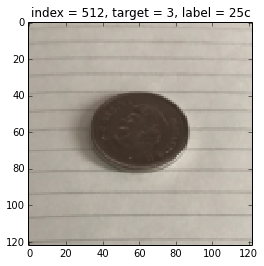

In [11]:
# sanity check
print("Y_train shape: " + str(train_set_y.shape))
print("Y_dev shape: " + str(dev_set_y.shape))
print("Y_test shape: " + str(test_set_y.shape))

index = np.random.randint(len(train_set_y))
target = np.argmax(train_set_y[index])
plt.title("index = " + str(index) + ", target = " + str(target) + ", label = " + target_label[str(target)])
photo = train_set_x[index].reshape(122, 122, 3)
plt.imshow(photo)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

baseline_model = Sequential()
baseline_model.add(Dense(1024, activation='relu', input_shape=(122*122*3,) ))
baseline_model.add(Dense(6, activation='softmax'))

In [ ]:
baseline_model.summary()

In [ ]:
baseline_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
baseline_model.fit(train_set_x, train_set_y, epochs=50, batch_size=32, validation_data=(dev_set_x, dev_set_y))

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(122, 122, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.summary()

In [14]:
from keras import optimizers

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

In [31]:
history = model.fit(train_set_x, train_set_y, epochs=10, batch_size=128, 
                    validation_data=(dev_set_x, dev_set_y))

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 29s 38ms/step - loss: 0.0343 - acc: 0.9909 - val_loss: 8.8522 - val_acc: 0.2656
Epoch 2/10
768/768 [==============================] - 29s 38ms/step - loss: 0.0313 - acc: 0.9922 - val_loss: 9.2292 - val_acc: 0.2552
Epoch 3/10
768/768 [==============================] - 28s 37ms/step - loss: 0.0283 - acc: 0.9935 - val_loss: 8.9844 - val_acc: 0.2448
Epoch 4/10
768/768 [==============================] - 29s 37ms/step - loss: 0.0297 - acc: 0.9935 - val_loss: 9.1716 - val_acc: 0.2500
Epoch 5/10
768/768 [==============================] - 30s 39ms/step - loss: 0.0242 - acc: 0.9948 - val_loss: 9.4295 - val_acc: 0.2448
Epoch 6/10
768/768 [==============================] - 28s 37ms/step - loss: 0.0254 - acc: 0.9948 - val_loss: 9.6971 - val_acc: 0.2396
Epoch 7/10
768/768 [==============================] - 29s 38ms/step - loss: 0.0329 - acc: 0.9922 - val_loss: 9.2906 - val_acc: 0.2552
Epoch 8/10
768/7

In [ ]:
history_3 = history

In [ ]:
model.save('testing3.h5')

In [ ]:
import pickle

In [ ]:
with open('history3_3.pickle', 'wb') as f:
    pickle.dump(history_3.history, f)

In [ ]:
history_2.history['acc']

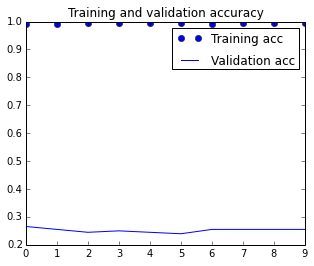

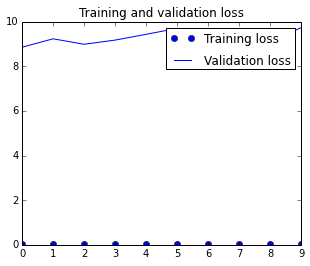

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
with open('experiments/logistic_regression/learning_rate_0.0001/history.pickle', 'rb') as f:
    tmp = pickle.load(f)

In [ ]:
tmp['acc']